# **Vocal Biomarker Estimator for Parkinson’s Disease**

 **Notebook 1/2 - AI-Based Early Detection of Parkinson's Disease from Speech**
### AAI-590 Capstone Project

**Author:** Arifa Kokab  
**Group:** 11 (Solo)  
**Program:** M.Sc. Applied Artificial Intelligence  
**School:** University of San Diego - Shiley-Marcos School of Engineering  

*Launched under CarePath AI Foundation (Non-Profit)*

#INTRODUCTION
This notebook is the first of two in my project titled "Vocal Biomarker Estimator for Parkinson's Disease." Here, the goal is to accurately and reliably screen individuals using voice data to determine if they are likely healthy or have Parkinson’s Disease (PD) using artificial intelligence.

**Goal:**

Build a reliable, explainable voice-based screener that classifies *status* (0 = Healthy, 1 = PD) using acoustic features (jitter, shimmer, HNR, etc.).

__

About the dataset:

The Oxford Parkinson's Disease Detection Dataset, containing voice features and status labels for PD and healthy cases.


Reference:
  Max A. Little, Patrick E. McSharry, Eric J. Hunter, Lorraine O. Ramig (2008). "Suitability of dysphonia measurements for telemonitoring of Parkinson's disease." IEEE Transactions on Biomedical Engineering

  Retrieved from: https://archive.ics.uci.edu/dataset/174/parkinsons

## Libraries & Environment
We begin by importing all the essential libraries needed for this project. Pandas and NumPy are used for handling and manipulating data, while scikit-learn provides the machine learning tools for splitting the dataset, tuning the model, scaling data, and evaluating its performance. Matplotlib and Seaborn help us create visualizations that make trends and relationships in the data easier to understand. We also import Google Colab's Drive integration to connect to our dataset stored in Google Drive, and Joblib to save the trained model for later use in a Vite + React application. This setup ensures we have everything ready for both analysis and deployment.

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Machine learning
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Google Colab - Drive Integration
from google.colab import drive, files

# Saving files for Deployment on a Streamlit App
import joblib

## Data Load & First Glance
Next, we mount Google Drive so the dataset can be accessed directly within our Colab environment. We read the Parkinson’s disease voice dataset into a Pandas DataFrame and display the first few rows to confirm it loaded correctly. We check the shape of the dataset to understand how many rows and columns we have, examine the data types of each feature, and verify there are no missing values. Finally, we review the class distribution for the target variable `status` and visualize it using a count plot to identify any imbalance between healthy and Parkinson’s cases.

In [ ]:
# Mount my Google Drive to access files
drive.mount('/content/drive')

# Path to the data file
data_path = '/content/drive/My Drive/Datasets for Capstone Project/parkinsons2/parkinsons.data'

# Read the data, usually the delimiter is comma
df = pd.read_csv(data_path)

# Show first few rows
df.head()

Mounted at /content/drive


,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


#**EXPLORATORY DATA ANALYSIS**

## Descriptive Statistics & Cleanup
With the data loaded, we calculate descriptive statistics to see measures like mean, standard deviation, and percentiles for each feature. This helps us understand the range and spread of the values. We then remove the `name` column since it is an identifier and does not contain any information useful for prediction. This leaves us with only the numeric features that can be fed into a machine learning model.

(195, 24)
name                 object
MDVP:Fo(Hz)         float64
MDVP:Fhi(Hz)        float64
MDVP:Flo(Hz)        float64
MDVP:Jitter(%)      float64
MDVP:Jitter(Abs)    float64
MDVP:RAP            float64
MDVP:PPQ            float64
Jitter:DDP          float64
MDVP:Shimmer        float64
MDVP:Shimmer(dB)    float64
Shimmer:APQ3        float64
Shimmer:APQ5        float64
MDVP:APQ            float64
Shimmer:DDA         float64
NHR                 float64
HNR                 float64
status                int64
RPDE                float64
DFA                 float64
spread1             float64
spread2             float64
D2                  float64
PPE                 float64
dtype: object
name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ          

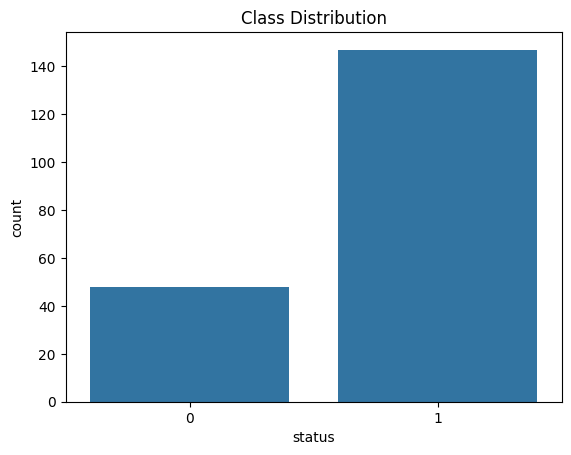


Descriptive statistics:
       MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
count   195.000000    195.000000    195.000000      195.000000   
mean    154.228641    197.104918    116.324631        0.006220   
std      41.390065     91.491548     43.521413        0.004848   
min      88.333000    102.145000     65.476000        0.001680   
25%     117.572000    134.862500     84.291000        0.003460   
50%     148.790000    175.829000    104.315000        0.004940   
75%     182.769000    224.205500    140.018500        0.007365   
max     260.105000    592.030000    239.170000        0.033160   

       MDVP:Jitter(Abs)    MDVP:RAP    MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
count        195.000000  195.000000  195.000000  195.000000    195.000000   
mean           0.000044    0.003306    0.003446    0.009920      0.029709   
std            0.000035    0.002968    0.002759    0.008903      0.018857   
min            0.000007    0.000680    0.000920    0.002040      0.00954

In [ ]:
# Dataset shape and data types
print(df.shape)
print(df.dtypes)

# Check for missing values
print(df.isnull().sum())

# Class balance
print(df['status'].value_counts())
sns.countplot(x='status', data=df)
plt.title('Class Distribution')
plt.show()

# Describe stats
print("\nDescriptive statistics:")
print(df.describe())

# Drop the name column
df = df.drop('name', axis=1)

## Visualizing EDA
We visualize feature histograms to see distribution shape—many acoustic measures are right-skewed, which is normal for jitter/shimmer style metrics. The correlation heatmap shows tight clusters among jitter and shimmer features and a contrasting pattern with HNR, which often moves in the opposite direction of noise-related measures. These patterns match voice science and hint that a tree-based model can leverage these correlated families well.

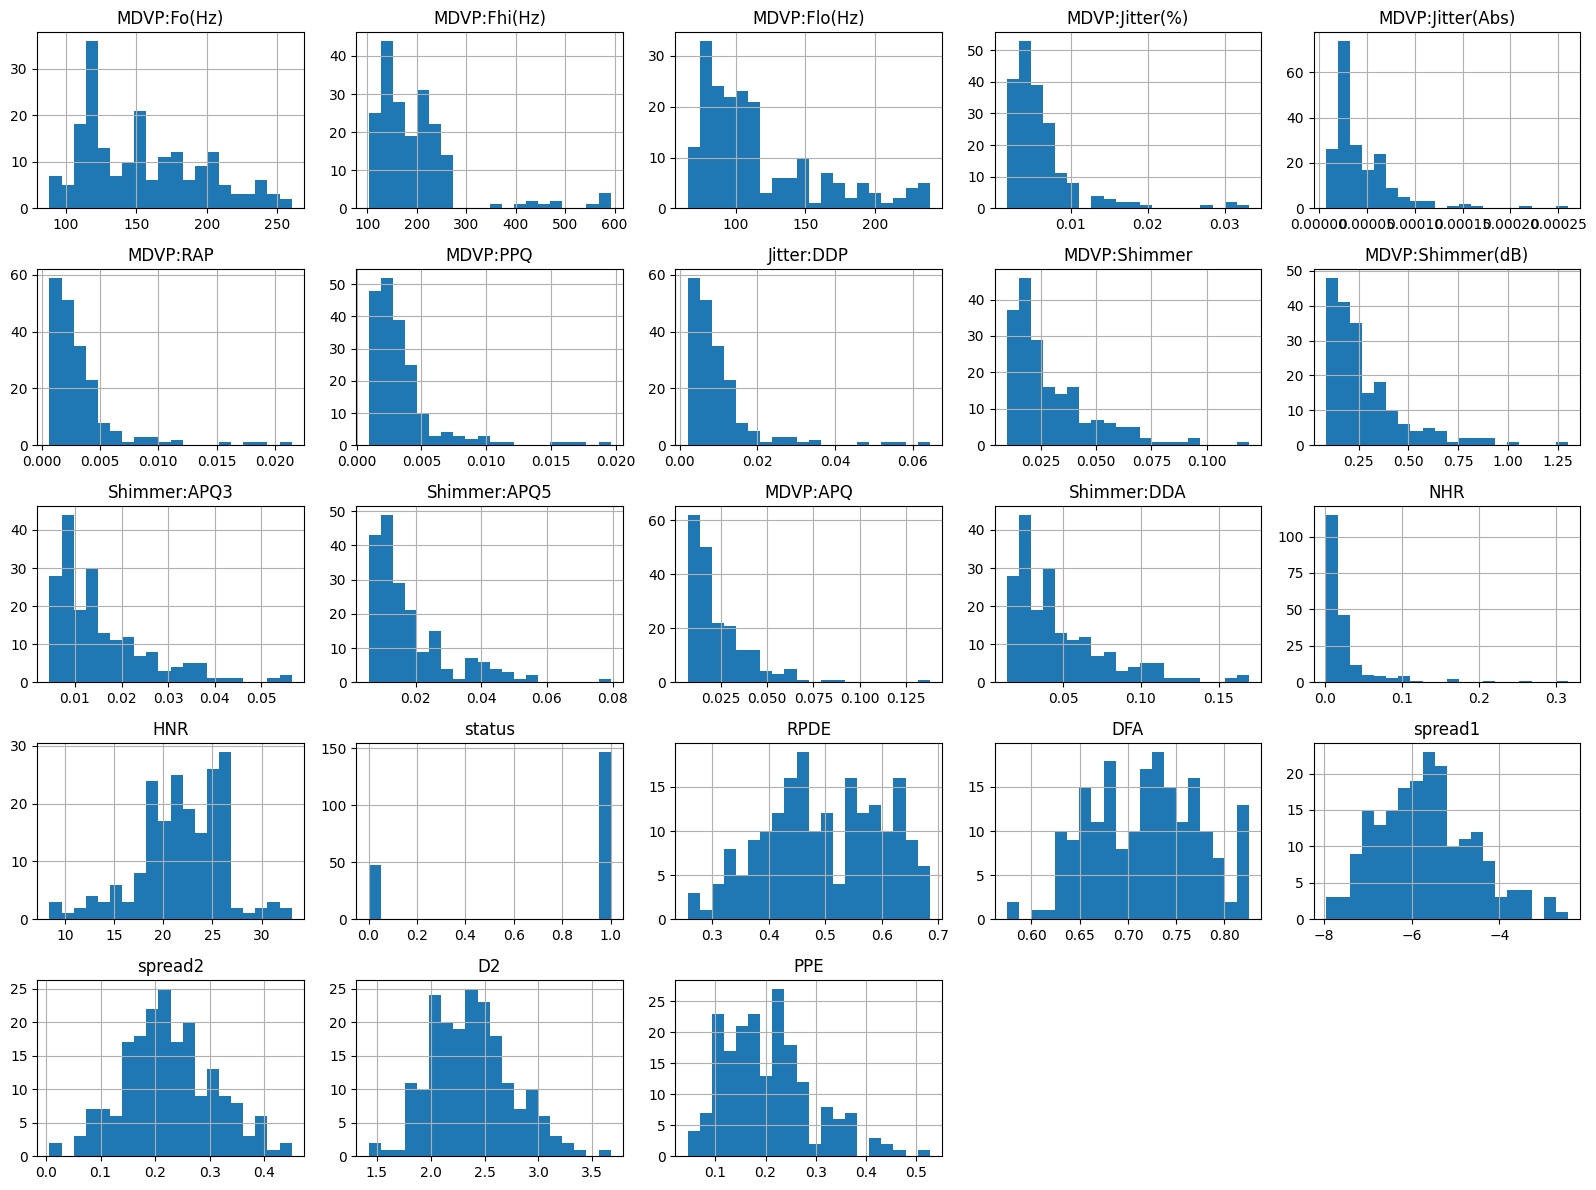

In [ ]:
# Histograms for each feature (to see distributions)
df.hist(figsize=(16, 12), bins=20)
plt.tight_layout()
plt.show()

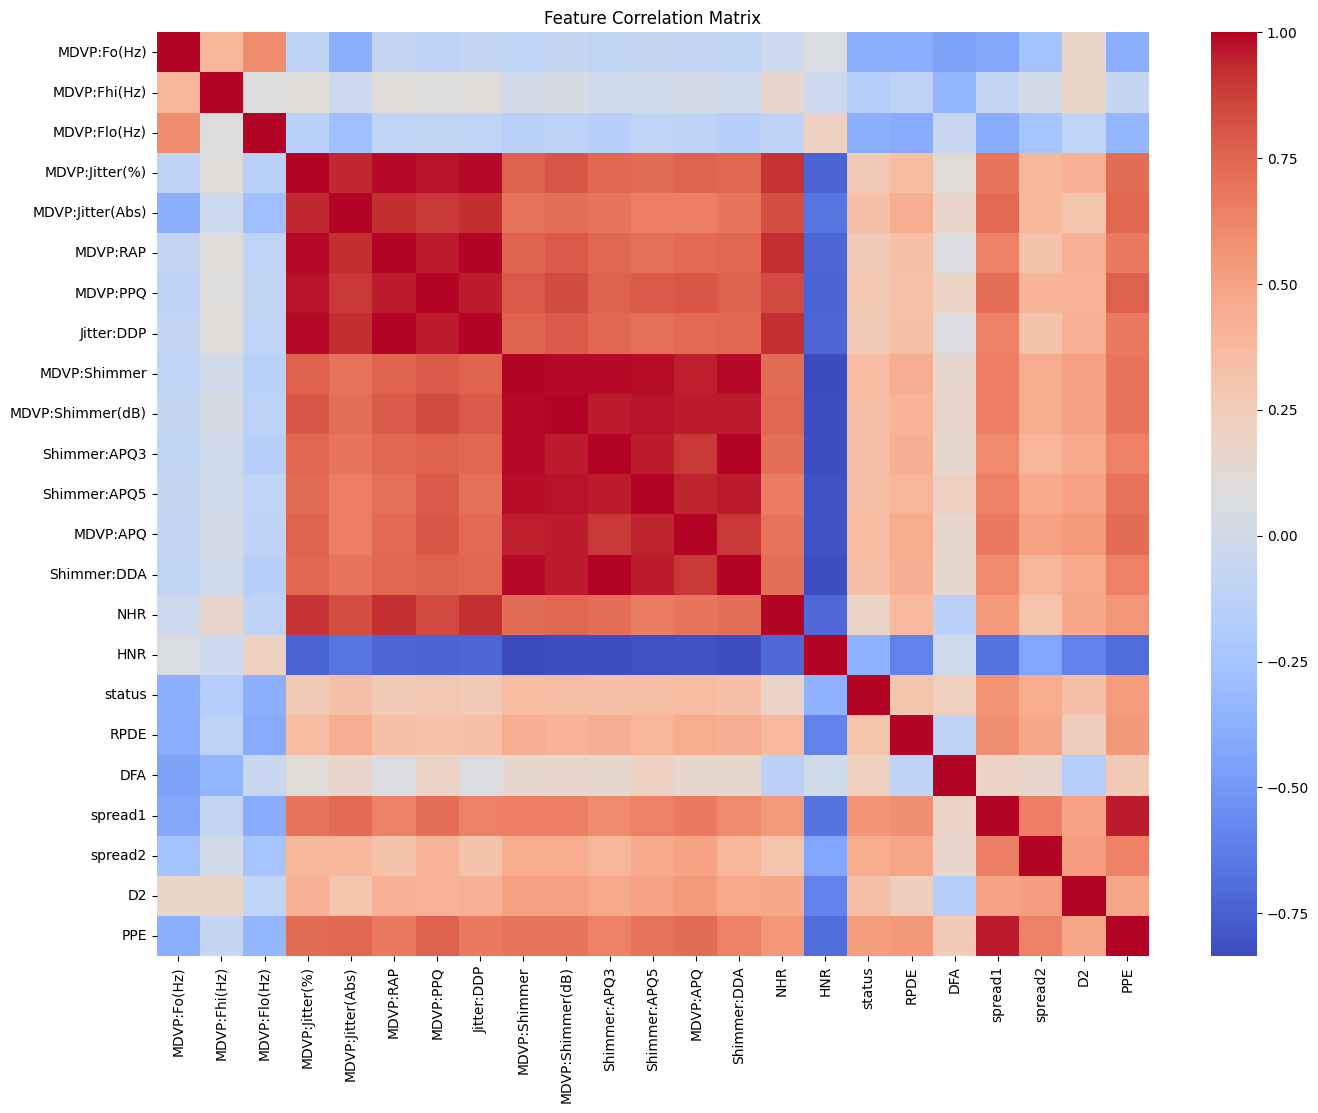

In [ ]:
# Correlation matrix heatmap
plt.figure(figsize=(16,12))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Matrix")
plt.show()

## Feature Selection
Based on both practical and predictive considerations, we select a subset of features that are informative and can be easily extracted from audio in real-world applications. These include pitch-related statistics, jitter measures, shimmer measures, and noise-related measures such as NHR and HNR. We define these as our feature matrix `X` and set our target variable `y` to the `status` column, which indicates whether the voice recording belongs to a healthy individual or someone with Parkinson’s disease.

In [ ]:
# Select only those features that are suitable as well as can be easily extracted from audio that is useful for deployment

features_for_model = [
    'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)',
    'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
    'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA',
    'NHR', 'HNR'
]

X = df[features_for_model]
y = df['status']

## Train/Test Split
We split the dataset into training and testing sets using stratified sampling, ensuring that the ratio of healthy to Parkinson’s cases is preserved in both sets. This is important for maintaining the same class balance during both training and evaluation, especially since the dataset has more Parkinson’s cases than healthy ones. This step ensures our evaluation metrics on the test set will be a fair reflection of real-world performance.

In [ ]:
# Split the data into training and testing sets with stratification to keep class proportions.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#**MODEL BUILDING AND TRAINING**

## Model Building & Hyperparameter Tuning
We train a Random Forest with `class_weight='balanced'` so the model does not ignore the smaller healthy class. Using a 5-fold Stratified GridSearch, we explore tree depth, number of trees, and split/leaf sizes and optimize for weighted F1. The best setup found was 100 trees, unlimited depth, `max_features='sqrt'`, `min_samples_split=2`, and `min_samples_leaf=1`, with a cross-validated weighted F1 of **0.879**. This gives us a strong, consistent baseline for screening.


In [ ]:
# Use GridSearchCV to find the best hyperparameters for Random Forest. Use class_weight to handle class imbalance.

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(
    rf, param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1, verbose=2
)
grid_search.fit(X_train, y_train)
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validated F1 score:", grid_search.best_score_)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Best parameters found: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validated F1 score: 0.8789862404810929


#**MODEL EVALUATION**

## Test Set Evaluation
After finding the best hyperparameters, we fit the tuned model on the training set and evaluate its performance on the unseen test set. We generate a classification report showing precision, recall, and F1-score for both healthy and Parkinson’s classes, and we plot a confusion matrix to visualize correct and incorrect predictions. This step helps us understand the model’s strengths and weaknesses before making any threshold adjustments.

In [ ]:
# Evaluate the best model on the test set.

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Healthy", "PD"]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.88      0.70      0.78        10
          PD       0.90      0.97      0.93        29

    accuracy                           0.90        39
   macro avg       0.89      0.83      0.86        39
weighted avg       0.90      0.90      0.89        39

Confusion Matrix:
 [[ 7  3]
 [ 1 28]]


**Test Set Evaluation (Default Threshold) Explanation**

On the hold-out test set, the tuned model reaches **90% accuracy** at the default threshold of 0.50. The classification report shows Healthy (precision 0.88, recall 0.70, F1 0.78) and PD (precision 0.90, recall 0.97, F1 0.93). The confusion matrix [[7, 3], [1, 28]] makes the trade-off clear: the model is very sensitive to PD but misses some healthy cases, which is acceptable to start for a screening tool that prioritizes catching PD.

## Feature Importance
To make the model more interpretable, we examine the feature importances produced by the Random Forest. This reveals which features the model relies on most when making predictions. Seeing jitter, shimmer, and HNR near the top of the list aligns well with clinical expectations, as these are known to be affected by Parkinson’s disease. This not only boosts trust in the model but also provides valuable insights for future feature engineering.

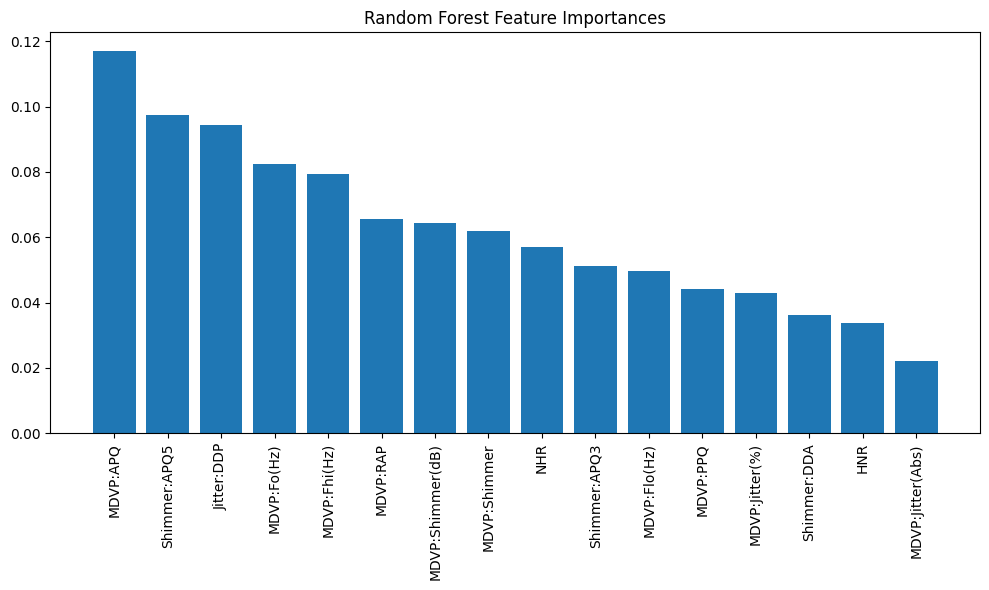

In [ ]:
# Feature Importance (Random Forest)

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = np.array(features_for_model)[indices]

plt.figure(figsize=(10,6))
plt.title("Random Forest Feature Importances")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), feature_names, rotation=90)
plt.tight_layout()
plt.show()

**Feature Importance Explanation**

Random Forest importances point to voice irregularity and amplitude perturbations as the main drivers: **MDVP:APQ** and **Shimmer:APQ5** lead, followed by **Jitter:DDP**, pitch statistics (Fo/Fhi), and other shimmer/jitter measures. NHR and HNR also contribute. This ranking aligns with clinical expectations for dysphonia in Parkinson’s and increases trust in the model’s decisions.


## ROC Curve & AUC
We calculate the predicted probabilities for the test set and plot the Receiver Operating Characteristic (ROC) curve, which shows the trade-off between sensitivity and specificity at different thresholds. The Area Under the Curve (AUC) is also calculated, giving us a single metric that reflects the model’s ability to distinguish between healthy and Parkinson’s cases. A higher AUC indicates better overall ranking performance.

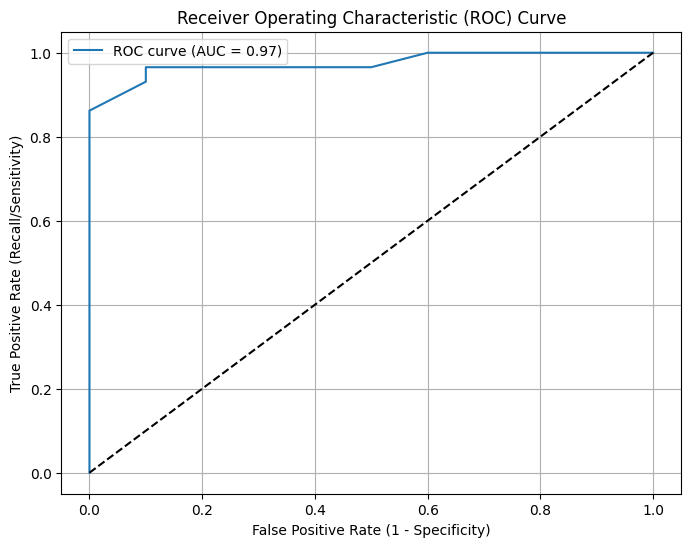

In [ ]:
# Visualize model performance across thresholds and calculate AUC.

probs = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc = roc_auc_score(y_test, probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall/Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

**ROC Curve & AUC Explanation**

We examine the model’s ranking quality with the ROC curve and achieve an **AUC of 0.97** on the test set. This indicates excellent separation between PD and healthy voices across a range of thresholds and confirms the model is robust before any threshold tuning.

## Threshold Tuning
Instead of relying on the default threshold of 0.5, we experiment with a custom threshold of 0.63 to adjust the balance between detecting Parkinson’s cases and avoiding false positives. This is particularly important in a screening context where missing a case could have significant consequences. We re-calculate the classification report and confusion matrix using this new threshold to see how it impacts recall and precision for both classes.

In [ ]:
# Apply the optimal threshold of 0.63 and show the new classification report and confusion matrix.

threshold = 0.63
custom_pred = (probs > threshold).astype(int)
print(f"Confusion Matrix (Threshold={threshold}):\n", confusion_matrix(y_test, custom_pred))
print(classification_report(y_test, custom_pred, target_names=["Healthy", "PD"]))

Confusion Matrix (Threshold=0.63):
 [[10  0]
 [ 4 25]]
              precision    recall  f1-score   support

     Healthy       0.71      1.00      0.83        10
          PD       1.00      0.86      0.93        29

    accuracy                           0.90        39
   macro avg       0.86      0.93      0.88        39
weighted avg       0.93      0.90      0.90        39



**Threshold Tuning (0.63) Explanation**

Because screening benefits from fewer missed healthy cases flagged as PD in our workflow, we raise the decision threshold to **0.63**. At this threshold the confusion matrix becomes [[10, 0], [4, 25]] with **accuracy 0.897**, **Healthy recall 1.00**, and **PD recall 0.862**. In words: we perfectly recover healthy cases on the test set and still correctly identify the majority of PD cases, while PD precision reaches 1.00. This is a clean, explainable trade-off for our use case.


## Metrics Summary
We summarize the model’s accuracy, as well as the recall for healthy and Parkinson’s classes, at the chosen threshold of 0.63. This concise summary gives a clear view of the trade-offs made with this threshold adjustment, making it easier for decision-makers to assess whether the performance is acceptable for a real-world screening tool.

In [ ]:
# Summarize model metrics at the chosen threshold.

print(f"At threshold {threshold}:")
print("Accuracy:", np.mean(custom_pred == y_test))
print("Healthy recall:", confusion_matrix(y_test, custom_pred)[0,0] / sum(y_test==0))
print("PD recall:", confusion_matrix(y_test, custom_pred)[1,1] / sum(y_test==1))

At threshold 0.63:
Accuracy: 0.8974358974358975
Healthy recall: 1.0
PD recall: 0.8620689655172413


**Metrics Summary Explanation**

**Default 0.50:** accuracy 0.90; Healthy—P=0.88, R=0.70, F1=0.78; PD—P=0.90, R=0.97, F1=0.93; confusion [[7,3],[1,28]].  

**Tuned 0.63:** accuracy 0.897; Healthy—P=0.71, R=1.00, F1=0.83; PD—P=1.00, R=0.862, F1=0.93; confusion [[10,0],[4,25]].  

Together with an ROC-AUC of **0.97**, these results show a high-quality screener whose behavior can be adjusted by threshold to match operational needs.


#**SAVE MODEL FOR EXPORT**

## Saving the Model
We export the final Random Forest as `rf_model.pkl` for deployment. Keep the threshold **0.63** as part of the inference logic so the app reproduces these test results. In production, load the pickle, compute the same features in the same order, call `predict_proba`, apply the 0.63 cutoff, and display the decision with the probability score.

In [ ]:
# Save the trained Random Forest model for deployment.

joblib.dump(best_rf, 'rf_model.pkl')
print("Model saved as rf_model.pkl")

# Download the model

files.download('rf_model.pkl')

Model saved as rf_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**MODEL SUMMARY**

### Model Performance Snapshot (rf_model)
- Best CV (5-fold, weighted F1): **0.879** with RF(n_estimators=100, max_depth=None, max_features='sqrt', min_samples_split=2, min_samples_leaf=1, class_weight='balanced').

- Test (default 0.50): accuracy **0.90**; Healthy—P=0.88, R=0.70, F1=0.78; PD—P=0.90, R=0.97, F1=0.93; CM [[7,3],[1,28]].

- Test (tuned **0.63**): accuracy **0.897**; Healthy—P=0.71, R=1.00, F1=0.83; PD—P=1.00, R=0.862, F1=0.93; CM [[10,0],[4,25]].

- ROC-AUC (test): **0.97**.

- Top RF importances: MDVP:APQ, Shimmer:APQ5, Jitter:DDP, MDVP:Fo(Hz), MDVP:Fhi(Hz), MDVP:RAP, MDVP:Shimmer(dB), MDVP:Shimmer, NHR, Shimmer:APQ3, MDVP:Flo(Hz), MDVP:PPQ, MDVP:Jitter(%), Shimmer:DDA, HNR, MDVP:Jitter(Abs).


#**CONCLUSION**

This notebook turns raw voice features into a practical Parkinson’s screening tool. The tuned Random Forest achieves a strong cross-validated weighted F1 of 0.879 and a test ROC-AUC of 0.97, showing excellent separation between PD and healthy voices. At the default threshold, the model is highly sensitive to PD; after tuning the threshold to 0.63, we reach perfect recall on healthy cases and still capture most PD cases with perfect precision. The feature importance profile—dominated by amplitude and frequency perturbation measures like APQ, shimmer, and jitter—matches clinical intuition about dysphonia in Parkinson’s, which increases the model’s credibility. The final artifact, `rf_model.pkl`, together with the 0.63 decision rule, is ready for deployment.